In [1]:
from IPython.core.display import HTML
def css_styling():
    styles = open("./custom.css", "r").read()
    return HTML(styles)
css_styling()

<img src="img/DAGA_logo.png" alt="DAGA Logo" style="width:160px; position:absolute; top:20px; right:0px;">
<img src="img/TU-lang.png" alt="TU Logo" style="width:230px; position:absolute; top:0px; right:180px;">

<h1 style="margin-top: 180px; margin-bottom: 50px; color: #A81D1E;">Getting Started with Acoular</h1>
<h3 style="margin-top: 50px; margin-bottom: 100px; color: #434343;">Art J. R. Pelling, Mikolaj Czuchaj, Gert Herold, Adam Kujawski, Oliver Lylloff, Ennes Sarradj</h2>


## What we will do

- import a microphone array geometry
- synthesize a multi-source scenario
- apply basic beamforming
- plot the results

In [2]:
# First things first
import acoular

### Load microphone geometry

In [3]:
acoular.MicGeom?

In [4]:
from pathlib import Path

mgpath = Path(acoular.__file__).parent / 'xml' / 'array_64.xml'
with open(mgpath, 'r') as f:
    for _ in range(5):
        print(f.readline())

<?xml version="1.0" encoding="utf-8"?>									

<MicArray name="array_64">									

	<pos Name="Point 	1	" x="	0.152	" y="	0.1141	" z="	0	"/>

	<pos Name="Point 	2	" x="	0.134	" y="	0.1021	" z="	0	"/>

	<pos Name="Point 	3	" x="	0.1043	" y="	0.1036	" z="	0	"/>



In [49]:
# check coordinates
mg = acoular.MicGeom( file = mgpath )
mg.pos[:,:3]

array([[0.152 , 0.134 , 0.1043],
       [0.1141, 0.1021, 0.1036],
       [0.    , 0.    , 0.    ]])

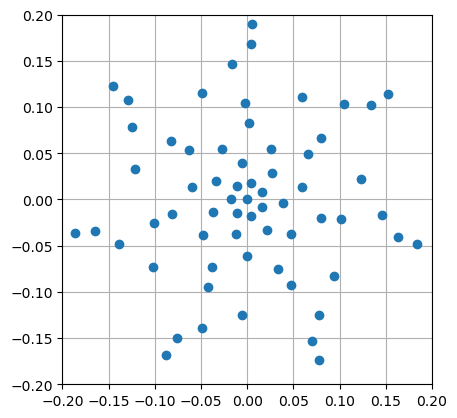

In [22]:
# visualize the microphone array
import matplotlib.pylab as plt

plt.plot( mg.pos[0], mg.pos[1], 'o' )
plt.grid()
plt.gca().set_aspect( 'equal', adjustable='box' )
plt.xlim((-0.2,0.2))
plt.ylim((-0.2,0.2));
# seven intertwined spirals

### Create a source case
- three point sources
- uncorrelated white noise

In [7]:
sfreq = 51200
duration = 1
num_samples = duration * sfreq

n1 = acoular.WNoiseGenerator(sample_freq=sfreq, num_samples=num_samples, seed=1)
n2 = acoular.WNoiseGenerator(sample_freq=sfreq, num_samples=num_samples, seed=2, rms=0.7)
n3 = acoular.WNoiseGenerator(sample_freq=sfreq, num_samples=num_samples, seed=3, rms=0.5)
p1 = acoular.PointSource(signal=n1, mics=mg, loc=(-0.1, -0.1, -0.3))
p2 = acoular.PointSource(signal=n2, mics=mg, loc=(0.15, 0, -0.3))
p3 = acoular.PointSource(signal=n3, mics=mg, loc=(0, 0.1, -0.3))

ts = acoular.Mixer(source=p1, sources=[p2, p3])

In [8]:
isinstance(ts, acoular.TimeOut)

True

We can use this object now to answer some questions about the data:
* How many channels,
* and how many samples do we have? 
* What is the sampling frequency? 

In [9]:
print( ts.num_channels, ts.num_samples, ts.sample_freq )

64 51200 51200.0


### Frequency Domain Processing
- signal processing can take place in the time domain or in the frequency domain
- need to transform the time domain data
- set blocksize and window

In [25]:
ps = acoular.PowerSpectra( source=ts, block_size=128, window="Hanning" )
ps.fftfreq()

array([    0.,   400.,   800.,  1200.,  1600.,  2000.,  2400.,  2800.,
        3200.,  3600.,  4000.,  4400.,  4800.,  5200.,  5600.,  6000.,
        6400.,  6800.,  7200.,  7600.,  8000.,  8400.,  8800.,  9200.,
        9600., 10000., 10400., 10800., 11200., 11600., 12000., 12400.,
       12800., 13200., 13600., 14000., 14400., 14800., 15200., 15600.,
       16000., 16400., 16800., 17200., 17600., 18000., 18400., 18800.,
       19200., 19600., 20000., 20400., 20800., 21200., 21600., 22000.,
       22400., 22800., 23200., 23600., 24000., 24400., 24800., 25200.,
       25600.])

### Cross Spectral Matrix (CSM)
- pairwise cross spectra of all channels
- computed using Welch's method
- _lazy evaluation_ => no computations so far!

In [50]:
ps.csm.shape

(np.int64(65), np.int64(64), np.int64(64))

### Set the Focus Grid

In [51]:
acoular.RectGrid?

In [37]:
rg = acoular.RectGrid( x_min=-0.2, x_max=0.2,
                       y_min=-0.2, y_max=0.2,
                       z=0.3, increment=0.01 )
rg.pos

array([[-0.2  , -0.2  , -0.2  , ...,  0.2  ,  0.2  ,  0.2  ],
       [-0.2  , -0.199, -0.198, ...,  0.198,  0.199,  0.2  ],
       [ 0.3  ,  0.3  ,  0.3  , ...,  0.3  ,  0.3  ,  0.3  ]])

### Compute the Source Map
- we use the _beamforming_ as our method
- combined microhpones are _steered_ to each point of the focus grid
- done by `SteeringVector` class

The actual method we will use is __beamforming__. Basically this works by using the combined microphones as a sound receiver with a directivity that is _steered_ to each one of the grid points in turn. One important element in beamforming and similar methods is the __steering vector__ implemented in Acoular in the `SteeringVector` class. This vector "connects" grid and microphones and takes into account the environmental conditions. These conditions are defined by the speed of sound and a possible background flow. If not set explicitely, a 'standard' environment is created in Acoular which assumes quiescent conditions (no flow) and a speed of sound of 343 m/s (air at 20°C).

In [55]:
st = acoular.SteeringVector( grid=rg, mics=mg )

`SteeringVector` takes environmental conditions into account.
Standard `Environment` is set per default.

In [59]:
st.env?

In [61]:
st.env.c

343.0

Set up a standard (basic) beamformer. For this need two ingredients: the CSM and the steering vector.

In [39]:
bb = acoular.BeamformerBase( freq_data=ps, steer=st )

__lazy evaluation__ => Still no computations!

### Compute the Beamforming Map
- compute and sum result for all frequencies in a certain range
- `num=3` for third-octave
- convert to SPL with `L_p`

In [67]:
f = 8000
num = 3

pm = bb.synthetic( f, num )
Lm = acoular.L_p( pm )
Lm.shape

(401, 401)

In [69]:
print(Lm.min(), Lm.max())

-350.0 92.31181750689572


The map has the same dimensions (41 x 41) as the grid. 
Any zero result in the map will be clipped to -350 dB level instead of -infinity.

Finally, lets plot the map!

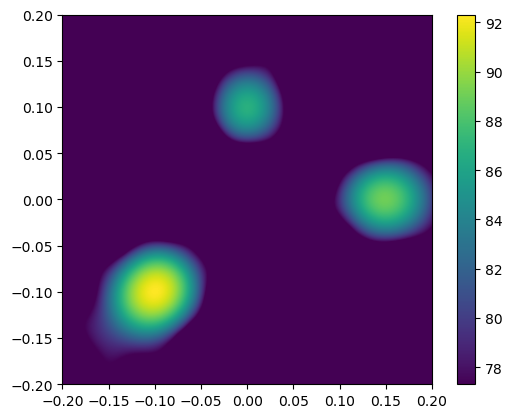

In [70]:
plt.figure()
plt.imshow( Lm.T, origin="lower", vmin=Lm.max()-15, extent=rg.extend() )
plt.colorbar();